In [1]:
import sys
import os
sys.path.append('..')

In [2]:
import json
import os
import time

import numpy as np
import torch
# from e3nn import o3
import torch.nn.functional as F
from torch.utils.data import Dataset
# from torch_geometric.data import Data

/home/holywater2/.conda/envs/infGCN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
path_dir = "../../../dataset_mp_mixed"

saved_files = os.listdir(path_dir)
saved_files_wo_ext = []
for i in saved_files:
    if i.split(".")[1] == "chgcar":
        saved_files_wo_ext.append(i.split(".")[0])

In [9]:
print(i)

mp-28939.chgcar


In [10]:
item = 0
file_pattern = ".chgcar"
file_list = saved_files_wo_ext
print(file_list[item])

file_name = f'{(file_list[item])}{file_pattern}'
data_path = path_dir

fileobj = open(os.path.join(data_path, file_name), 'r')

# atom_file = "crystal.json"
# with open(atom_file) as f:
#     atom_info = json.load(f)
# atom_list = [info["name"] for info in atom_info]
# atom_name2idx = {name: idx for idx, name in enumerate(atom_list)}

mp-626225


In [11]:
"""Read atoms and data from CHGCAR file."""
readline = fileobj.readline
readline()  # the first comment line
scale = float(readline())  # the scaling factor (lattice constant)

print("scale: ", scale)


scale:  1.0


In [12]:
# the upcoming three lines contain the cell information
cell = torch.empty(3, 3, dtype=torch.float)
for i in range(3):
    cell[i] = torch.FloatTensor([float(s) for s in readline().split()])
cell = cell * scale

print("cell: ", cell)


cell:  tensor([[ 6.1358,  0.0000,  0.0000],
        [ 0.0000,  6.1420,  0.0000],
        [ 0.0000,  0.2347, 11.3444]])


In [13]:
# the sixth line specifies the constituting elements
elements = readline().split()
# the seventh line supplies the number of atoms per atomic species
n_atoms = [int(s) for s in readline().split()]
# the eighth line is always "Direct" in our application
readline()

print("elements: ", elements)
print("n_atoms: ", n_atoms)

elements:  ['Ca', 'H', 'O']
n_atoms:  [2, 32, 20]


In [14]:
atom_file = "mp_mixed.json"
with open(atom_file) as f:
    atom_info = json.load(f)
atom_list = [info["name"] for info in atom_info]
atom_name2idx = {name: idx for idx, name in enumerate(atom_list)}

In [15]:
from tqdm import tqdm

In [31]:
elements_list = []
error = []
from tqdm import tqdm
for jj in tqdm(range(len(saved_files_wo_ext[:100]))):
    file_name = f'{(file_list[jj])}{file_pattern}'
    fileobj = open(os.path.join(data_path, file_name), 'r')
    readline = fileobj.readline
    readline()  # the first comment line
    scale = float(readline())  # the scaling factor (lattice constant)
    
    for i in range(3):
        [float(s) for s in readline().split()]
        
    elements = readline().split()
    n_atoms = [int(s) for s in readline().split()]
    
    elements_list.extend(elements)
    readline()
    tot_atoms = sum(n_atoms)
    # atom_type = torch.empty(tot_atoms, dtype=torch.long)
    atom_coord = torch.empty(tot_atoms, 3, dtype=torch.float)
    # the upcoming lines contains the atomic positions in fractional coordinates
    idx = 0
    for elem, n in zip(elements, n_atoms):
        # atom_type[idx : idx + n] = atom_name2idx[elem]
        for _ in range(n):
            [s for s in readline().split()]
            idx += 1
    # the coordinates are fractional, convert them to cartesian
    # atom_coord = atom_coord @ cell
    # g = Data(x=atom_type, pos=atom_coord)

    readline()  # an empty line
    shape = [int(s) for s in readline().split()]  # grid size
    n_grid = shape[0] * shape[1] * shape[2]
    # the grids are corner-aligned
    x_coord = (
        torch.linspace(0, shape[0] - 1, shape[0]).unsqueeze(-1) / shape[0] * cell[0]
    )
    y_coord = (
        torch.linspace(0, shape[1] - 1, shape[1]).unsqueeze(-1) / shape[1] * cell[1]
    )
    z_coord = (
        torch.linspace(0, shape[2] - 1, shape[2]).unsqueeze(-1) / shape[2] * cell[2]
    )
    grid_coord = (
        x_coord.view(-1, 1, 1, 3)
        + y_coord.view(1, -1, 1, 3)
        + z_coord.view(1, 1, -1, 3)
    )
    grid_coord = grid_coord.view(-1, 3)

    # the augmented occupancies are ignored
    density = [s for s in fileobj.read().split()[:n_grid]]
    dd = torch.tensor([float(val) for val in density])
    print(dd.max(), dd.min(), dd.mean())
    print(dd.draw_histogram())
    # density = len([s for s in fileobj.read().split()[:n_grid]])
    # the value stored is the charge within a grid instead of the charge density
    # divide the charge by the grid volume to get the density
    # volume = torch.linalg.det(cell).abs()
    # density = density / volume
    # CHGCAR file stores the density as Z-Y-X, convert them to X-Y-Z
    # print(f"count {jj}/{len(saved_files_wo_ext)}")
    print("mpid: ", file_list[jj])
    print("density: ", len(density))
    print("grid shape: ", shape, shape[0] * shape[1] * shape[2])
    if len(density) != shape[0] * shape[1] * shape[2]:
        print("[!] density shape not match")
        error.append(file_list[jj])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:03<?, ?it/s]

tensor(3530.1567) tensor(1.5520) tensor(172.)


AttributeError: 'Tensor' object has no attribute 'draw_histogram'

KeyboardInterrupt: 

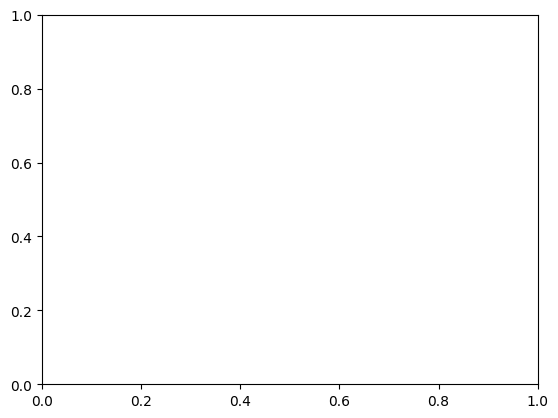

In [32]:
import matplotlib.pyplot as plt

# Assuming you have a list of data called 'data'
plt.hist(dd)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()


KeyboardInterrupt: 

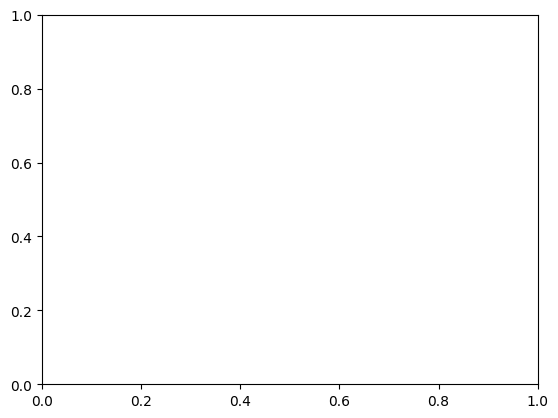

In [33]:
plt.hist(dd, bins=100)

In [42]:
import matplotlib.pyplot as plt

hist, bins = np.histogram(dd, bins=100)
plt.hist(dd, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()


In [28]:
torch.tensor([float(val) for val in density]).min()

tensor(1.5520)

In [39]:
import multiprocessing
def process_file(jj):
    file_name = f'{(file_list[jj])}{file_pattern}'
    fileobj = open(os.path.join(data_path, file_name), 'r')
    readline = fileobj.readline
    readline()  # the first comment line
    scale = float(readline())  # the scaling factor (lattice constant)
    
    for i in range(3):
        [s for s in readline().split()]
        
    elements = readline().split()
    n_atoms = [int(s) for s in readline().split()]
    
    elements_list.extend(elements)
    readline()
    tot_atoms = sum(n_atoms)
    atom_coord = torch.empty(tot_atoms, 3, dtype=torch.float)

    idx = 0
    for elem, n in zip(elements, n_atoms):
        for _ in range(n):
            [s for s in readline().split()]
            idx += 1

    readline()  # an empty line
    shape = [int(s) for s in readline().split()]  # grid size
    n_grid = shape[0] * shape[1] * shape[2]

    density = len([s for s in fileobj.read().split()[:n_grid]])
    # print("mpid: ", file_list[jj])
    # print("density: ", density)
    # print("grid shape: ", shape, shape[0] * shape[1] * shape[2])
    if density != shape[0] * shape[1] * shape[2]:
        print("[!] density shape not match",jj ,file_list[jj])
        error.append(file_list[jj])

# Create a pool of processes
pool = multiprocessing.Pool(64)

# Map the process_file function to each value of jj using the pool of processes
pool.map(process_file, range(len(saved_files_wo_ext)))

# Close the pool of processes
pool.close()


[!] density shape not match
[!] density shape not match
[!] density shape not match
[!] density shape not match


KeyboardInterrupt: 

In [ ]:
# mp-771910.chgcar

In [40]:
error

[]

In [22]:
len(saved_files_wo_ext)

16100

In [28]:
unique_elements = list(set(elements_list))
print(unique_elements)


['Tb', 'Cd', 'Pm', 'Tl', 'Ti', 'Ca', 'Al', 'Sb', 'Sm', 'Gd', 'La', 'Pt', 'Ni', 'Ta', 'N', 'Os', 'Se', 'Be', 'V', 'Ce', 'P', 'Li', 'Rh', 'Au', 'Pa', 'Ru', 'Sr', 'W', 'Rb', 'U', 'Ho', 'Re', 'Y', 'Cl', 'Sc', 'Xe', 'Zn', 'Tm', 'Dy', 'Lu', 'Ge', 'Nd', 'Ba', 'O', 'Np', 'Cr', 'Eu', 'Hg', 'Cu', 'Te', 'As', 'Br', 'Pr', 'Sn', 'Zr', 'Co', 'Cs', 'Pu', 'Si', 'Th', 'S', 'Mg', 'Kr', 'Na', 'H', 'I', 'Hf', 'Mn', 'Pb', 'Nb', 'Mo', 'Bi', 'Ac', 'B', 'K', 'Ir', 'In', 'C', 'Tc', 'Er', 'Fe', 'Ga', 'Pd', 'He', 'F', 'Ag']


In [32]:
from rdkit import Chem

pt = Chem.GetPeriodicTable()
atom_info = [
    {
        'name': a,
        'atom_num': pt.GetAtomicNumber(a),
        'radius': round(pt.GetRcovalent(a) / 0.529177, 5)  # convert to Bohr
    } for a in unique_elements
]

In [34]:
with open('mp_mixed.json', 'w') as f:
    json.dump(atom_info, f, indent=2)

In [35]:
len(atom_info)

86